The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


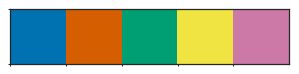

In [62]:
import sys
import os
from glob import glob
import re

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from IPython.display import display, Image, HTML
from statsmodels.sandbox.stats.multicomp import multipletests
import pandas as pd
import rpy2.robjects as robj

%load_ext rpy2.ipython
robj.pandas2ri.activate()

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
%%bash
source activate cgat_python2
awk -v FS='\t' -v OFS='\t' '{print $6, $4, $5}' ATH_GO_GOSLIM.txt | \
  sort -k1,1 | uniq > go_terms.txt

sort -k4,4 /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed > genes.bed
cut -d $'\t' -f1,6 ATH_GO_GOSLIM.txt | sort -k1,1 | grep -P '^AT\dG\d{5}' | uniq > go_genes.txt

head go_genes.txt

AT1G01010	GO:0003677
AT1G01010	GO:0003700
AT1G01010	GO:0005634
AT1G01010	GO:0006351
AT1G01010	GO:0006355
AT1G01010	GO:0007275
AT1G01010	GO:0016021
AT1G01020	GO:0003674
AT1G01020	GO:0005739
AT1G01020	GO:0005783


In [3]:
go = pd.read_table('go_genes.txt', sep='\t', names=['gene_id', 'go_term'])
go = go.drop_duplicates()
go.head()

,gene_id,go_term
0,AT1G01010,GO:0003677
1,AT1G01010,GO:0003700
2,AT1G01010,GO:0005634
3,AT1G01010,GO:0006351
4,AT1G01010,GO:0006355


In [4]:
%%bash
source activate cgat_python2

g4predict intra \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b g4.bed \
  -s \
  -F \
  -tmin 2 \
  -tmax 2 \
  -lmin 1 \
  -lmax 7

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: intra
INFO:root:Parameters:
{       'bed': 'g4.bed',
        'fasta': '/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa',
        'filter_overlapping': True,
        'func': <function intra at 0x7fbbb8615c08>,
        'merge_overlapping': False,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {       'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {       'start': 2, 'stop': 3},
        'loop_kwargs_list': [       {       'allow_G': 1, 'start': 1, 'stop': 7},
                                    {       'allow_G': 1, 'start': 1, 'stop': 7},
                                    {       'allow_G': 1, 'start': 1, 'stop': 7}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor': 20},
      

In [5]:
%%bash
source activate cgat_python2

cgat gtf2gtf --method=merge-exons --filter=proteincoding \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | \
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' > exons.bed

join -j 1 -t $'\t' <( 
    bedtools intersect -c -s \
      -a exons.bed\
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7} END \
                     {for (i in count) {print i,count[i]}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -c -S \
      -a exons.bed \
      -b /tmp/tair10_g4.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],len[i]}}' | \
    sort -k1,1d) \
    > ./exonic_g4_counts.tsv
head exonic_g4_counts.tsv

AT1G01010	1	2	1688
AT1G01020	0	0	1571
AT1G01030	0	1	1905
AT1G01040	9	2	6279
AT1G01050	0	0	1165
AT1G01060	1	3	3421
AT1G01070	0	1	1831
AT1G01080	1	0	1774
AT1G01090	2	3	1896
AT1G01100	2	1	856


In [6]:
g4_counts = pd.read_table('exonic_g4_counts.tsv',
                          sep='\t',
                          names=['gene_id', 'coding', 'template', 'gene_length'],
                          index_col='gene_id')
g4_counts['length_weight'] = g4_counts.gene_length / g4_counts.gene_length.sum()
g4_counts.head()

,coding,template,gene_length,length_weight
gene_id,,,,
AT1G01010,1,2,1688,0.000029
AT1G01020,0,0,1571,0.000027
AT1G01030,0,1,1905,0.000032
AT1G01040,9,2,6279,0.000106
AT1G01050,0,0,1165,0.000020


In [7]:
go_descriptions = pd.read_table(
    'go_terms.txt',
    sep='\t',
    names=['go_term', 'relationship', 'description'],
    index_col='go_term')
go_descriptions.head()

,relationship,description
go_term,,
GO:0000002,involved in,mitochondrial genome maintenance
GO:0000003,involved in,reproduction
GO:0000009,has,"alpha-1,6-mannosyltransferase activity"
GO:0000012,involved in,single strand break repair
GO:0000014,has,single-stranded DNA endodeoxyribonuclease acti...


In [8]:
def random_permute(size, weights):
    nbins = len(weights)
    idx = np.arange(nbins)
    perm = np.random.choice(idx,
                            size=size,
                            replace=True,
                            p=weights)
    counts = np.bincount(perm, minlength=nbins)
    return counts

In [9]:
niter = 10000
coding_exp = np.zeros((g4_counts.shape[0], niter), dtype=np.uint8)
template_exp = np.zeros((g4_counts.shape[0], niter), dtype=np.uint8)

for i in range(niter):
    coding_exp[:, i] = random_permute(g4_counts.coding.sum(),
                                      g4_counts.length_weight.values)
    template_exp[:, i] = random_permute(g4_counts.template.sum(),
                                        g4_counts.length_weight.values)

In [10]:
def two_sided_p_value(obs, exp):
    tot = len(exp)
    enrich_pval = (exp > obs).sum() / tot
    deplet_pval = (exp < obs).sum() / tot
    pval = np.min([enrich_pval, deplet_pval])
    return np.max([1 / tot, pval])

go_enrichment = {}

for go_term, group in go.groupby('go_term'):
    go_idx = g4_counts.index.isin(group.gene_id)
    coding_obs, template_obs = g4_counts.loc[
        go_idx, ['coding', 'template']].sum(0)
    coding_exp_dist = coding_exp[go_idx].sum(0)
    coding_p_val = two_sided_p_value(coding_obs, coding_exp_dist)
    template_exp_dist = template_exp[go_idx].sum(0)
    template_p_val = two_sided_p_value(template_obs, template_exp_dist)
    go_enrichment[go_term] = [
        coding_obs,
        coding_exp_dist.mean(),
        coding_exp_dist.std(),
        coding_p_val,
        template_obs,
        template_exp_dist.mean(),
        template_exp_dist.std(),
        template_p_val,
    ]

go_enrichment = pd.DataFrame.from_dict(go_enrichment, orient='index')
go_enrichment.columns = ['coding_obs', 'coding_exp', 'coding_exp_std', 'coding_p_val', 
                         'template_obs', 'template_exp', 'template_std', 'template_p_val']
_, go_enrichment['coding_fdr'], *_ = multipletests(go_enrichment.coding_p_val, method='FDR_BH')
_, go_enrichment['template_fdr'], *_ = multipletests(go_enrichment.template_p_val, method='FDR_BH')
go_enrichment['coding_logFC'] = np.log2((go_enrichment.coding_obs + 1) / (go_enrichment.coding_exp + 1))
go_enrichment['template_logFC'] = np.log2((go_enrichment.template_obs + 1) / (go_enrichment.template_exp + 1))
go_enrichment = go_descriptions.join(go_enrichment, how='right')
go_enrichment.head()

,relationship,description,coding_obs,coding_exp,coding_exp_std,coding_p_val,template_obs,template_exp,template_std,template_p_val,coding_fdr,template_fdr,coding_logFC,template_logFC
GO:0000002,involved in,mitochondrial genome maintenance,4.0,6.7795,2.589764,0.0927,1.0,4.5362,2.135343,0.0104,0.203441,0.032984,-0.637749,-1.468896
GO:0000003,involved in,reproduction,39.0,19.3607,4.388781,0.0001,8.0,12.9333,3.650130,0.0601,0.000873,0.125134,0.974213,-0.630540
GO:0000009,has,"alpha-1,6-mannosyltransferase activity",2.0,1.6804,1.305395,0.2402,1.0,1.1109,1.064425,0.2994,0.322839,0.337577,0.162514,-0.077858
GO:0000012,involved in,single strand break repair,1.0,2.6791,1.637658,0.0687,1.0,1.8074,1.354956,0.1698,0.176239,0.250706,-0.879353,-0.489235
GO:0000014,has,single-stranded DNA endodeoxyribonuclease acti...,3.0,8.6026,2.941713,0.0078,3.0,5.7803,2.395461,0.0691,0.040205,0.138813,-1.263425,-0.761349


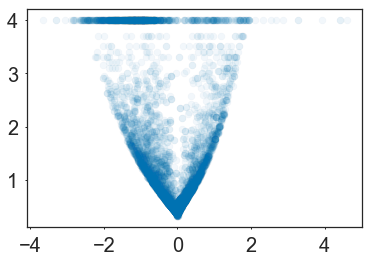

In [11]:
plt.scatter(x=go_enrichment.template_logFC, y=-np.log10(go_enrichment.template_p_val), alpha=0.05)
plt.show()

In [12]:
go_enrichment.sort_values(['template_fdr', 'template_logFC'], ascending=[True, False]).head()

,relationship,description,coding_obs,coding_exp,coding_exp_std,coding_p_val,template_obs,template_exp,template_std,template_p_val,coding_fdr,template_fdr,coding_logFC,template_logFC
GO:0009530,located in,primary cell wall,0.0,3.8815,1.993955,0.0001,85.0,2.5674,1.597829,0.0001,0.000873,0.000485,-2.287325,4.591392
GO:0005199,functions as,structural constituent of cell wall,40.0,68.8036,8.272909,0.0001,992.0,45.8931,6.730176,0.0001,0.000873,0.000485,-0.767678,4.404346
GO:0005199,has,structural constituent of cell wall,40.0,68.8036,8.272909,0.0001,992.0,45.8931,6.730176,0.0001,0.000873,0.000485,-0.767678,4.404346
GO:0000904,involved in,cell morphogenesis involved in differentiation,0.0,4.9099,2.204945,0.0001,64.0,3.2799,1.835526,0.0001,0.000873,0.000485,-2.563134,3.924791
GO:0009664,involved in,plant-type cell wall organization,84.0,98.0556,9.782817,0.0663,647.0,65.5273,7.951657,0.0001,0.172838,0.000485,-0.220776,3.283975


In [13]:
!grep 'GO:0000904' go_genes.txt

AT1G12040	GO:0000904
AT1G62440	GO:0000904


In [14]:
nmm_vs_cntrl = pd.read_csv(
    '../tair10_nmm_rnaseq/nmm_rnaseq_differential_expression_05022018.tsv',
    sep='\t', index_col=0)
nmm_vs_cntrl.head()

,logFC,logCPM,LR,PValue,FDR,A_Negative,A_NMM,B_Negative,B_NMM,C_Negative,C_NMM
AT1G01010,0.848345,5.679371,86.897764,1.142785e-20,7.723917e-20,6.061120,5.201267,6.034207,5.238690,5.921129,5.313969
AT1G01020,-0.112609,4.284573,1.324880,2.497181e-01,3.226948e-01,4.124961,4.582637,4.191397,4.386639,4.207503,4.132619
AT1G01030,-0.148465,1.414800,0.749500,3.866346e-01,4.668409e-01,1.078083,1.697544,1.392574,1.630670,1.186892,1.211171
AT1G01040,0.170917,5.911781,4.577984,3.238530e-02,5.303067e-02,5.791820,5.888296,6.026004,5.919526,5.944691,5.884326
AT1G01050,-0.462401,6.045595,33.003445,9.199573e-09,3.281001e-08,5.646266,6.270310,5.695635,6.362601,5.786667,6.313878


In [15]:
nmm_vs_cntrl['downreg'] = ((nmm_vs_cntrl.FDR < 0.05) &
                           (nmm_vs_cntrl.logFC < -1)).astype(int)
nmm_vs_cntrl['upreg'] = ((nmm_vs_cntrl.FDR < 0.05) &
                         (nmm_vs_cntrl.logFC > 1)).astype(int)
downreg = pd.Series(nmm_vs_cntrl.downreg)
upreg = pd.Series(nmm_vs_cntrl.upreg)
downreg.head()

AT1G01010    0
AT1G01020    0
AT1G01030    0
AT1G01040    0
AT1G01050    0
Name: downreg, dtype: int64

In [16]:
gene_lengths = pd.read_table(
    '../tair10_nmm_rnaseq/salmon_output/A_Negative/quant.sf',
    usecols=[0, 1])
gene_lengths['Name'] = gene_lengths.Name.str.split('.', expand=True)[0]
gene_lengths = gene_lengths.groupby('Name').median()['Length']
gene_lengths = gene_lengths[downreg.index].values

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiasedUrn

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: geneLenDataBase

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)


          DEgenes bias.data        pwf
AT1G01010       0    1688.0 0.10378379
AT1G01020       0    1317.5 0.11168232
AT1G01030       0    1870.5 0.09998910
AT1G01040       0    6076.5 0.03675810
AT1G01050       0     902.0 0.12070679
AT1G01060       0    2715.0 0.08362596


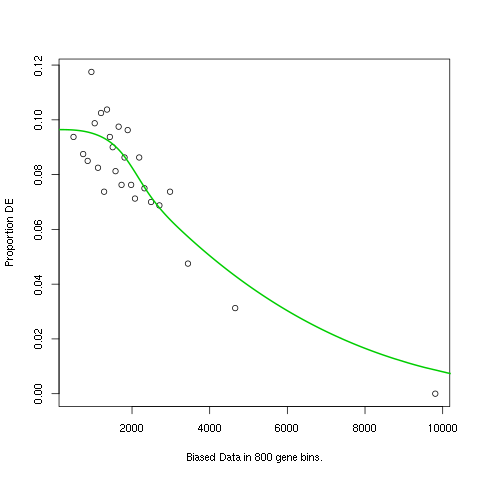

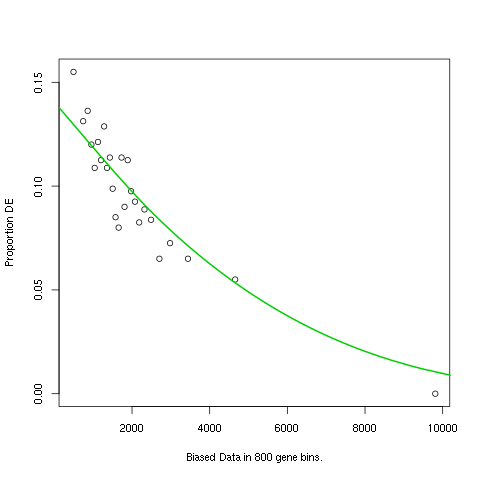

In [17]:
%%R -i downreg,upreg,gene_lengths
library(goseq)
pwf_d <- nullp(downreg, bias.data=gene_lengths)
pwf_u <- nullp(upreg, bias.data=gene_lengths)
head(pwf_u)

In [18]:
%%R -o go_down,go_up
go_map <- read.table('./go_genes.txt',
                     sep='\t',
                     col.names=c('ensembl_gene_id', 'go_id'))
go_down <- goseq(pwf_d, gene2cat=go_map)
go_up <- goseq(pwf_u, gene2cat=go_map)

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using manually entered categories.

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: For 461 genes, we could not find any categories. These genes will be excluded.

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: To force their use, please run with use_genes_without_cat=TRUE (see documentation).

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: This was the default behavior for version 1.15.1 and earlier.

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarnin

In [19]:
go_res_ = {'up': go_up, 'down': go_down}
for k, go_res in go_res_.items():
    go_res = go_res.copy()
    go_res['p_val'] = go_res[['over_represented_pvalue', 'under_represented_pvalue']].min(1)
    go_res['de_type'] = go_res[['over_represented_pvalue', 'under_represented_pvalue']].idxmin(1)
    go_res['de_type'] = go_res.de_type.map({'over_represented_pvalue': '+',
                                            'under_represented_pvalue': '-'})
    go_res.drop(['over_represented_pvalue', 'under_represented_pvalue', 'term'], axis=1, inplace=True)
    _, go_res['fdr'], *_ = multipletests(go_res.p_val, method='FDR_BH')
    go_res.columns = ['go_id', 'de_in_cat', 'tot_in_cat',
                     'ontology_type', 'nmm_vs_cntrl_p_val', 'nmm_vs_cntrl_de_type', 'nmm_vs_cntrl_fdr']
    go_res = go_res.set_index('go_id')
    go_res_[k] = go_res
go_res = go_res_['down'].join(
    go_res_['up'].drop(['tot_in_cat', 'ontology_type'], axis=1),
    lsuffix='_downreg',
    rsuffix='_upreg',
)
go_res.head()

,de_in_cat_downreg,tot_in_cat,ontology_type,nmm_vs_cntrl_p_val_downreg,nmm_vs_cntrl_de_type_downreg,nmm_vs_cntrl_fdr_downreg,de_in_cat_upreg,nmm_vs_cntrl_p_val_upreg,nmm_vs_cntrl_de_type_upreg,nmm_vs_cntrl_fdr_upreg
go_id,,,,,,,,,,
GO:0047134,74,109,MF,1.407178e-55,+,8.635851e-53,2,1.420904e-03,-,6.707758e-02
GO:0005576,303,1433,CC,5.617225e-55,+,3.133901e-52,214,2.419508e-09,+,5.303043e-07
GO:0055114,227,1151,BP,1.493142e-35,+,7.636178e-33,153,2.990409e-04,+,1.952355e-02
GO:0020037,79,259,MF,1.367551e-24,+,6.455893e-22,51,3.090656e-06,+,3.578746e-04
GO:0005506,63,238,MF,6.827186e-17,+,2.992746e-14,39,1.414045e-03,+,6.707758e-02


In [20]:
go_g4_nmm = go_res.join(go_enrichment)
go_g4_nmm.head()

,de_in_cat_downreg,tot_in_cat,ontology_type,nmm_vs_cntrl_p_val_downreg,nmm_vs_cntrl_de_type_downreg,nmm_vs_cntrl_fdr_downreg,de_in_cat_upreg,nmm_vs_cntrl_p_val_upreg,nmm_vs_cntrl_de_type_upreg,nmm_vs_cntrl_fdr_upreg,...,coding_exp_std,coding_p_val,template_obs,template_exp,template_std,template_p_val,coding_fdr,template_fdr,coding_logFC,template_logFC
GO:0000002,0,3,BP,0.781181,-,0.965397,0,0.738876,-,0.953654,...,2.589764,0.0927,1.0,4.5362,2.135343,0.0104,0.203441,0.032984,-0.637749,-1.468896
GO:0000003,0,6,BP,0.665974,-,0.965397,0,0.608621,-,0.953654,...,4.388781,0.0001,8.0,12.9333,3.650130,0.0601,0.000873,0.125134,0.974213,-0.630540
GO:0000009,0,1,MF,0.911856,-,0.965397,0,0.896481,-,0.953654,...,1.305395,0.2402,1.0,1.1109,1.064425,0.2994,0.322839,0.337577,0.162514,-0.077858
GO:0000012,0,1,BP,0.932993,-,0.965397,0,0.917018,-,0.953654,...,1.637658,0.0687,1.0,1.8074,1.354956,0.1698,0.176239,0.250706,-0.879353,-0.489235
GO:0000014,0,4,MF,0.718486,-,0.965397,0,0.668549,-,0.953654,...,2.941713,0.0078,3.0,5.7803,2.395461,0.0691,0.040205,0.138813,-1.263425,-0.761349


In [21]:
go_g4_nmm[go_g4_nmm.tot_in_cat > 25].sort_values('template_logFC', ascending=False).head()

,de_in_cat_downreg,tot_in_cat,ontology_type,nmm_vs_cntrl_p_val_downreg,nmm_vs_cntrl_de_type_downreg,nmm_vs_cntrl_fdr_downreg,de_in_cat_upreg,nmm_vs_cntrl_p_val_upreg,nmm_vs_cntrl_de_type_upreg,nmm_vs_cntrl_fdr_upreg,...,coding_exp_std,coding_p_val,template_obs,template_exp,template_std,template_p_val,coding_fdr,template_fdr,coding_logFC,template_logFC
GO:0005199,14,28,MF,4.244968e-09,+,9.648655e-07,1,0.243020,-,0.953654,...,8.272909,0.0001,992.0,45.8931,6.730176,0.0001,0.000873,0.000485,-0.767678,4.404346
GO:0005199,14,28,MF,4.244968e-09,+,9.648655e-07,1,0.243020,-,0.953654,...,8.272909,0.0001,992.0,45.8931,6.730176,0.0001,0.000873,0.000485,-0.767678,4.404346
GO:0009664,24,52,BP,9.567017e-13,+,3.090147e-10,4,0.359625,-,0.953654,...,9.782817,0.0663,647.0,65.5273,7.951657,0.0001,0.172838,0.000485,-0.220776,3.283975
GO:0016722,5,27,MF,6.035406e-02,+,9.653969e-01,7,0.011356,+,0.292828,...,8.666109,0.1507,136.0,51.0776,7.086634,0.0001,0.260550,0.000485,0.149629,1.395441
GO:0031225,28,181,CC,2.612660e-03,+,1.142093e-01,34,0.001044,+,0.052959,...,17.967995,0.4344,553.0,216.0495,14.731926,0.0001,0.439390,0.000485,0.008920,1.351862


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Background RRGGBBAA: ffffff00
Area 0:0:1280:833.751 exported to 1280 x 834 pixels (90 dpi)
Bitmap saved as: go_g4_nmm_enrichment_table.png


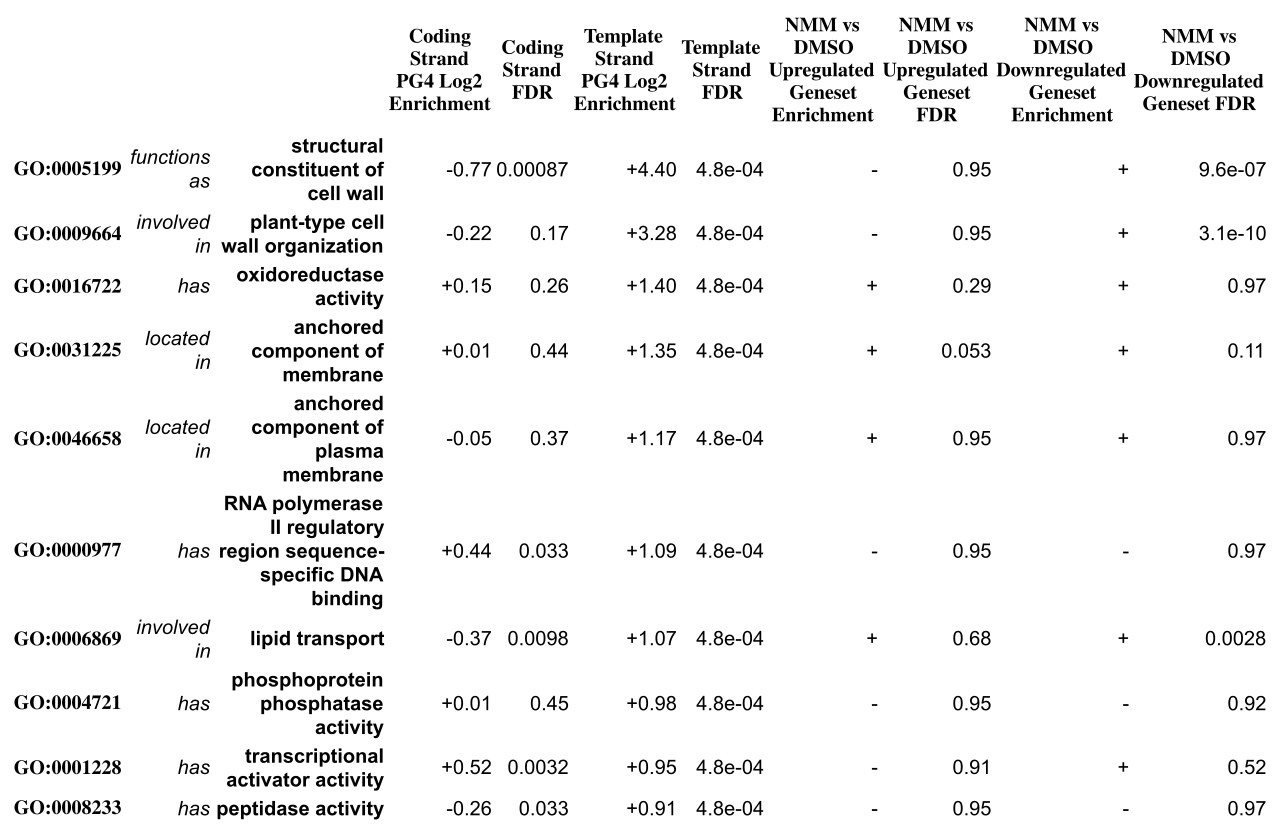

In [70]:
display_cols = ['relationship', 'description',
                'coding_logFC', 'coding_fdr',
                'template_logFC', 'template_fdr',
                'nmm_vs_cntrl_de_type_upreg', 'nmm_vs_cntrl_fdr_upreg',
                'nmm_vs_cntrl_de_type_downreg', 'nmm_vs_cntrl_fdr_downreg']
table = go_g4_nmm[go_g4_nmm.tot_in_cat > 25].sort_values('template_logFC', ascending=False)[display_cols].drop_duplicates(subset='description').head(n=10)
table['description'] = table.description.str.split(',', expand=True)[0]
table.columns = [' ', '  ', 
                 'Coding Strand PG4 Log2 Enrichment', 
                 'Coding Strand FDR', 
                 'Template Strand PG4 Log2 Enrichment', 
                 'Template Strand FDR', 
                 'NMM vs DMSO Upregulated Geneset Enrichment', 
                 'NMM vs DMSO Upregulated Geneset FDR',
                 'NMM vs DMSO Downregulated Geneset Enrichment', 
                 'NMM vs DMSO Downregulated Geneset FDR']
table = table.style.format({'NMM vs DMSO Upregulated Geneset FDR': '{:1.2g}',
                            'NMM vs DMSO Downregulated Geneset FDR': '{:1.2g}',
                            'Template Strand FDR': '{:.1e}',
                            'Coding Strand FDR': '{:.2g}',
                            'Template Strand PG4 Log2 Enrichment': '{:+.2f}',
                            'Coding Strand PG4 Log2 Enrichment': '{:+.2f}'})
table.set_properties(**{'width': '75px', 'text-align': 'right', 'font-family': 'arial'})
table.set_properties(subset=['  '], width='150px')
table.set_properties(**{'font-weight': 'bold'}, subset=['  '])
table.set_properties(**{'font-style': 'italic'}, subset=[' '])
with open('go_g4_nmm_enrichment_table.html', 'w') as f:
    f.write(table.render())

!wkhtmltoimage go_g4_nmm_enrichment_table.html go_g4_nmm_enrichment_table.svg
!inkscape -e go_g4_nmm_enrichment_table.png go_g4_nmm_enrichment_table.svg
Image(filename='go_g4_nmm_enrichment_table.png', width=500)

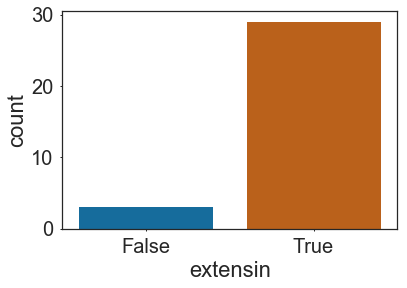

29
90.625


In [476]:
go_cell_wall_comp = pd.read_table('go0005199.txt', sep='\t', index_col=False)
go_cell_wall_comp['extensin'] = ((go_cell_wall_comp['Gene Model Description'].str.contains('extensin', flags=re.IGNORECASE)) |
                                 (go_cell_wall_comp['Primary Gene Symbol'].str.contains('extensin', flags=re.IGNORECASE)))
go_cell_wall_comp['lrx'] = go_cell_wall_comp['Gene Model Description'].str.contains('Leucine-rich repeat', flags=re.IGNORECASE)
go_cell_wall_comp['order'] = go_cell_wall_comp.extensin * 2 - go_cell_wall_comp.lrx
sns.countplot(go_cell_wall_comp.extensin)
plt.show()
print(go_cell_wall_comp.extensin.sum())
print(100 * (go_cell_wall_comp.extensin.sum() / len(go_cell_wall_comp)))

In [477]:
nmm_melt = pd.melt(
    nmm_vs_cntrl.reset_index(),
    id_vars=['index', 'FDR'],
    value_vars=['A_Negative', 'B_Negative', 'C_Negative', 'A_NMM', 'B_NMM', 'C_NMM'],
    var_name='condition',
    value_name='expression')
nmm_melt['condition'] = nmm_melt.condition.str[2:]
nmm_melt['condition'] = nmm_melt['condition'].astype('category')
nmm_melt.condition.cat.categories = ['DMSO', 'NMM']
nmm_melt = nmm_melt.sort_values(by='index')
nmm_melt.head()

,index,FDR,condition,expression
0,AT1G01010,7.723917e-20,NMM,6.061120
60120,AT1G01010,7.723917e-20,DMSO,5.201267
80160,AT1G01010,7.723917e-20,DMSO,5.238690
40080,AT1G01010,7.723917e-20,NMM,5.921129
100200,AT1G01010,7.723917e-20,DMSO,5.313969


In [478]:
g4_counts.head()

,coding,template,gene_length,length_weight
gene_id,,,,
AT1G01010,1,2,1688,0.000029
AT1G01020,0,0,1571,0.000027
AT1G01030,0,1,1905,0.000032
AT1G01040,9,2,6279,0.000106
AT1G01050,0,0,1165,0.000020


In [479]:
g4s_melt = pd.melt(
    g4_counts.reset_index(),
    id_vars=['gene_id', 'gene_length'],
    value_vars=['coding', 'template'],
    var_name='strand',
    value_name='PG4s'
)
g4s_melt['PG4/kb'] = (g4s_melt.PG4s / g4s_melt.gene_length) * 1000
g4s_melt.head()

,gene_id,gene_length,strand,PG4s,PG4/kb
0,AT1G01010,1688,coding,1,0.592417
1,AT1G01020,1571,coding,0,0.000000
2,AT1G01030,1905,coding,0,0.000000
3,AT1G01040,6279,coding,9,1.433349
4,AT1G01050,1165,coding,0,0.000000


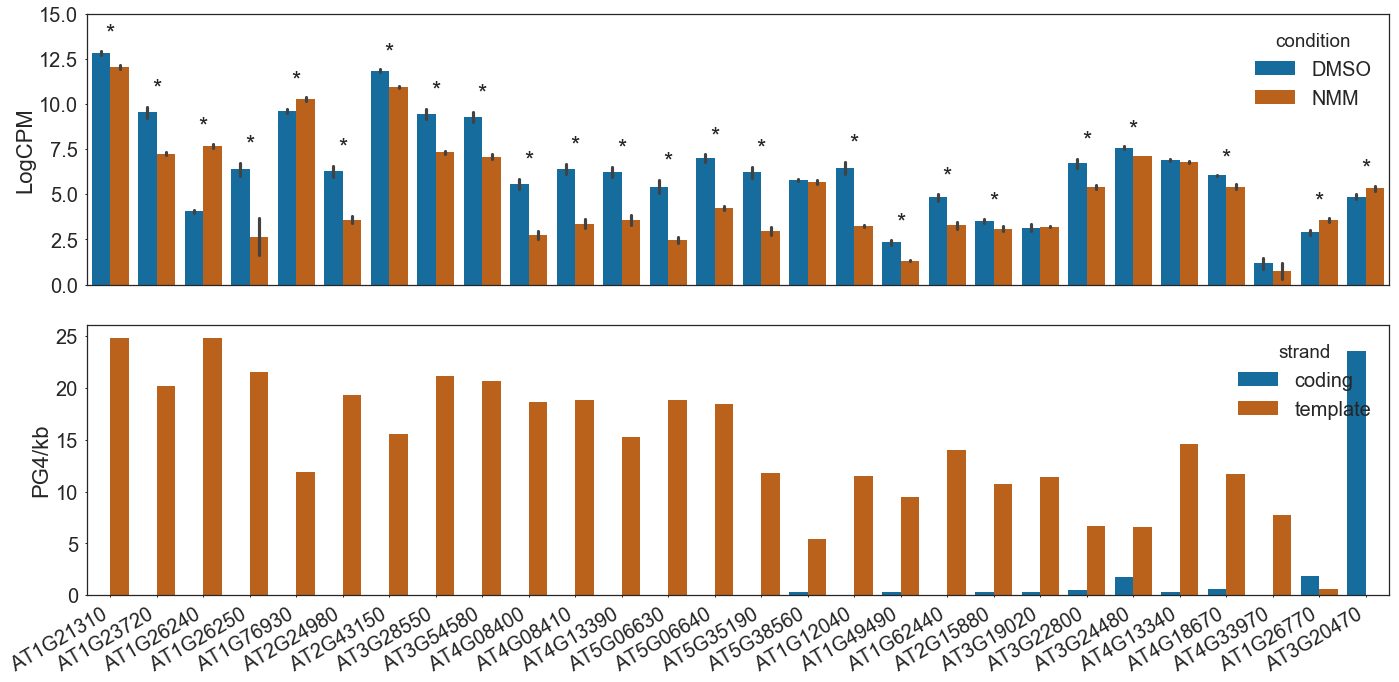

In [481]:
fig, axes = plt.subplots(figsize=(20, 10), nrows=2)
data = nmm_melt[nmm_melt['index'].isin(go_cell_wall_comp['Locus Identifier'])]
order = go_cell_wall_comp.sort_values(
    ['order', 'Locus Identifier'], ascending=[False, True])['Locus Identifier']
order = [x for x in order if x in data['index'].values]
sns.barplot(
    x='index',
    y='expression',
    hue='condition',
    data=data,
    order=order,
    ci='sd',
    ax=axes[0],
)
axes[0].set_xticks([])
fdrs = data.drop_duplicates(subset=('index'))
for x, idx in enumerate(order):
    fdr = fdrs.loc[fdrs['index'] == idx, 'FDR']
    y = data.loc[data['index'] == idx, 'expression'].max()
    if float(fdr) < 0.05:
        axes[0].annotate(xy=(x - 0.1, y + 0.5), s='*')

axes[0].set_ylim(0, 15)
axes[0].set_xlabel('')
axes[0].set_ylabel('LogCPM')

g4_data = g4s_melt[g4s_melt['gene_id'].isin(go_cell_wall_comp['Locus Identifier'])]
sns.barplot(
    x='gene_id',
    y='PG4/kb',
    hue='strand',
    data=g4_data,
    order=order,
    ci='sd',
    ax=axes[1],
)
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')
axes[1].set_xlabel('')
plt.tight_layout()
plt.savefig('go0005199_nmm_exprs.svg')
plt.show()

In [482]:
x[x.strand == 'template']['PG4/kb'].min()

AttributeError: 'int' object has no attribute 'strand'

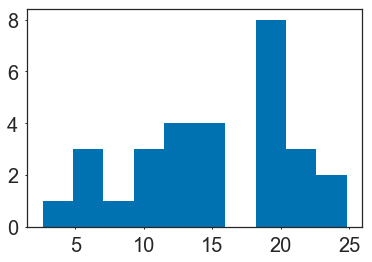

In [447]:
x = g4s_melt[g4s_melt.gene_id.isin(go_cell_wall_comp.loc[go_cell_wall_comp.extensin, 'Locus Identifier'].values)]
plt.hist(x[x.strand == 'template']['PG4/kb'])
plt.show()

In [449]:
len(x[x.strand == 'template'])

29

In [362]:
data[['index', 'FDR']].drop_duplicates().set_index('index')[order]

KeyError: "['AT5G38560' 'AT1G21310' 'AT4G13390' 'AT5G06640' 'AT1G76930' 'AT5G06630'\n 'AT3G28550' 'AT2G24980' 'AT3G54580' 'AT4G08400' 'AT1G26240' 'AT1G26250'\n 'AT1G12040' 'AT1G62440' 'AT2G43150' 'AT1G23720' 'AT4G08410' 'AT4G13340'\n 'AT5G35190' 'AT3G20470' 'AT3G24480' 'AT1G26770' 'AT1G49490' 'AT3G19020'\n 'AT4G33970' 'AT3G22800' 'AT2G15880' 'AT4G18670'] not in index"